In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# 
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machine-failure-prediction/ai4i2020.csv


In [2]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('/kaggle/input/machine-failure-prediction/ai4i2020.csv')
del data['Product ID']
del data['Type']

print( data.columns)

Index(['UDI', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')


In [4]:
data.isnull().sum()

UDI                        0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [5]:
data = data.astype({'Air temperature [K]':'int64'})
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Air temperature [K]      10000 non-null  int64  
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-null  int64  
 11  RNF                      10000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 937.6 KB


In [6]:
data = data.astype({'Process temperature [K]':'int64'})
data = data.astype({'Torque [Nm]':'int64'})

In [7]:
%matplotlib inline
import os

from keras.models import Sequential
from keras.layers import Dense

from numpy.random import randn
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [8]:
data.isnull().sum()

UDI                        0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [9]:
data.shape

(10000, 12)

In [10]:
# we are only using some columns of the 
features = ['UDI','Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'RNF','OSF','PWF']

label = ['Machine failure']
X = data[features]
y = data[label]

In [11]:
print (y)

      Machine failure
0                   0
1                   0
2                   0
3                   0
4                   0
...               ...
9995                0
9996                0
9997                0
9998                0
9999                0

[10000 rows x 1 columns]


# GAN

In [12]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [13]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n_samples, 1))
	return X, y

In [14]:
# generate n real samples with class labels
def generate_real_samples(n):
  X = data.sample(n)

  #generate class labels
  y = np.ones((n, 1))
  return X, y

In [15]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=12):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(30, activation='relu'))
  # model.add(Dense(n_outputs, activation='sigmoid'))
  model.add(Dense(n_outputs, activation='linear'))
  return model

In [16]:
generator1 = define_generator(13, 12)
generator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                210       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 12)                372       
                                                                 
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_________________________________________________________________


In [18]:
# define the standalone discriminator model
def define_discriminator(n_inputs=12):
  model = Sequential()
  # model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer='he_uniform', input_shape=n_inputs))
  # model.add(BatchNormalization())
  # model.add(LeakyReLU(alpha=0.2))
  # model.add(Dense(25, activation='relu'))
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [19]:

discriminator = define_discriminator(12)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                325       
                                                                 
 dense_4 (Dense)             (None, 50)                1300      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,676
Trainable params: 1,676
Non-trainable params: 0
_________________________________________________________________


In [21]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [22]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
	# plot loss
	plt.subplot(1, 1, 1)
	plt.plot(d_hist, label='d')
	plt.plot(g_hist, label='gen')
	# plt.legend()
	# plot discriminator accuracy
	# pyplot.subplot(2, 1, 2)
	# pyplot.plot(a1_hist, label='acc-real')
	# pyplot.plot(a2_hist, label='acc-fake')
	plt.show()
	# save plot to file
	# plt.savefig('results_baseline/plot_line_plot_loss.png')
	plt.close()

In [23]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=2000, n_batch=100):
  
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)
  d_history = []
  g_history = []
  
  # manually enumerate epochs
  for epoch in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
    d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    
    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    
    # update the generator via the discriminator's error
    g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
    print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
    d_history.append(d_loss)
    g_history.append(g_loss_fake)
  plot_history(d_history, g_history)
    # if i==999:
    #   np.savetxt("new_X.csv", X, delimiter=",")
    
    # evaluate the model every n_eval epochs
    # if (i+1) % n_eval == 0:
    #   summarize_performance(i, g_model, d_model, latent_dim)
  g_model.save('trained_generated_model_20210205_v3.h5')

In [24]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], color='red')
	pyplot.scatter(x_fake[:, 0], color='blue')
	pyplot.show()

In [25]:
# pip install os
# pip install matplotlib
import matplotlib


2/2 [==============================] - 2s 5ms/step
>1, d1=0.000, d2=0.691 d=0.345 g=0.738
2/2 [==============================] - 0s 3ms/step
>2, d1=0.000, d2=0.642 d=0.321 g=0.766
2/2 [==============================] - 0s 3ms/step
>3, d1=0.000, d2=0.624 d=0.312 g=0.832
2/2 [==============================] - 0s 3ms/step
>4, d1=0.000, d2=0.602 d=0.301 g=0.847
2/2 [==============================] - 0s 3ms/step
>5, d1=10.162, d2=0.555 d=5.359 g=0.894
2/2 [==============================] - 0s 2ms/step
>6, d1=0.000, d2=0.565 d=0.282 g=0.907
2/2 [==============================] - 0s 3ms/step
>7, d1=0.000, d2=0.530 d=0.265 g=0.947
2/2 [==============================] - 0s 2ms/step
>8, d1=0.000, d2=0.539 d=0.269 g=0.969
2/2 [==============================] - 0s 3ms/step
>9, d1=0.000, d2=0.478 d=0.239 g=1.010
2/2 [==============================] - 0s 3ms/step
>10, d1=0.000, d2=0.471 d=0.236 g=0.988
2/2 [==============================] - 0s 3ms/step
>11, d1=0.000, d2=0.469 d=0.234 g=1.014
2/2 [==

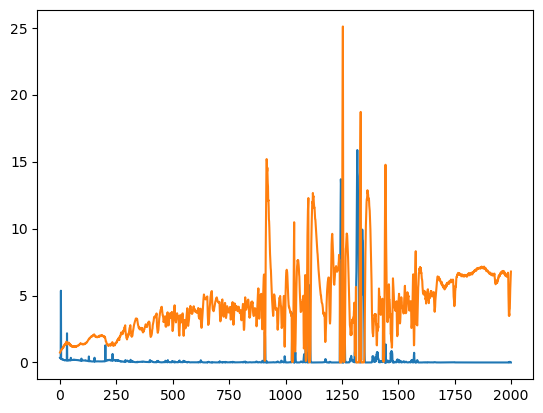

In [26]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [27]:

from keras.models import load_model
model = load_model('trained_generated_model_20210205_v3.h5')

In [48]:
latent_points = generate_latent_points(10, 10000)

In [49]:
X = model.predict(latent_points)


313/313 [==============================] - 0s 1ms/step


In [50]:
print( X)

[[319.08017  -53.338745 -33.04128  ...  37.038464  28.272552 -33.966717]
 [441.24695  -71.1147   -45.691563 ...  49.6656    39.658005 -45.56886 ]
 [353.25598  -59.502346 -37.139896 ...  40.9559    32.02899  -37.52734 ]
 ...
 [425.10217  -68.87191  -43.757366 ...  47.58978   37.58047  -42.790047]
 [386.18573  -62.419376 -40.186604 ...  43.28838   33.940033 -38.847454]
 [300.77478  -50.1244   -31.524834 ...  34.65253   26.942823 -31.725504]]


In [51]:
data_fake = pd.DataFrame(data=X,  columns = ['Machine Failure','UDI','Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'RNF','OSF','PWF'])

In [52]:
data_fake.head()

,Machine Failure,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,RNF,OSF,PWF
0,319.080170,-53.338745,-33.041279,-4.665645,-11.537077,16.028906,37.011894,75.596016,7.952993,37.038464,28.272552,-33.966717
1,441.246948,-71.114700,-45.691563,-6.828959,-17.101021,26.488230,48.585285,100.816750,8.374025,49.665600,39.658005,-45.568859
2,353.255981,-59.502346,-37.139896,-6.824886,-13.421418,18.532379,40.534943,83.812180,8.574550,40.955898,32.028992,-37.527340
3,491.469147,-81.182465,-51.925999,-7.879797,-18.715229,27.763994,55.243713,114.370338,10.658288,56.745258,44.086132,-51.235004
4,423.574585,-70.338181,-45.700974,-6.712283,-15.708828,23.769941,47.408958,98.894890,9.052464,48.700741,37.854877,-44.355927


In [53]:
len(data_fake)

10000

In [54]:
Machine_failure_mean = data_fake['Machine Failure'].mean()

conditional_function = lambda x: 0 if x > Machine_failure_mean else 1

data_fake['Machine Failure'] = data_fake['Machine Failure'].apply(conditional_function)

TWF_mean = data_fake['TWF'].mean()
HDF_mean = data_fake['HDF'].mean()
RNF_mean = data_fake['RNF'].mean()

In [55]:
data_fake.head()

,Machine Failure,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,RNF,OSF,PWF
0,1,-53.338745,-33.041279,-4.665645,-11.537077,16.028906,37.011894,75.596016,7.952993,37.038464,28.272552,-33.966717
1,0,-71.114700,-45.691563,-6.828959,-17.101021,26.488230,48.585285,100.816750,8.374025,49.665600,39.658005,-45.568859
2,1,-59.502346,-37.139896,-6.824886,-13.421418,18.532379,40.534943,83.812180,8.574550,40.955898,32.028992,-37.527340
3,0,-81.182465,-51.925999,-7.879797,-18.715229,27.763994,55.243713,114.370338,10.658288,56.745258,44.086132,-51.235004
4,0,-70.338181,-45.700974,-6.712283,-15.708828,23.769941,47.408958,98.894890,9.052464,48.700741,37.854877,-44.355927


In [56]:
data_fake.to_csv('data_fake.csv',index=False)

In [57]:
X.shape

(10000, 12)

In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machine-failure-prediction/ai4i2020.csv


In [59]:
fake_data = pd.read_csv('/kaggle/working/data_fake.csv')
# del data['Product ID']
# del data['Type']
# del data['UDI']
# del data['PWF']
# del data['OSF']
print(fake_data.columns)

Index(['Machine Failure', 'UDI', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'TWF', 'HDF', 'RNF', 'OSF', 'PWF'],
      dtype='object')


In [60]:
fake_data = fake_data.astype({'Torque [Nm]':'int64'})
fake_data = fake_data.astype({'Process temperature [K]':'int64'})
fake_data = fake_data.astype({'Machine Failure':'int64'})
fake_data = fake_data.astype({'Air temperature [K]':'int64'})
fake_data = fake_data.astype({'Rotational speed [rpm]':'int64'})
fake_data = fake_data.astype({'Tool wear [min]':'int64'})
fake_data = fake_data.astype({'Tool wear [min]':'int64'})
fake_data = fake_data.astype({'TWF':'int64'})
fake_data = fake_data.astype({'HDF':'int64'})
fake_data = fake_data.astype({'PWF':'int64'})
fake_data = fake_data.astype({'OSF':'int64'})
fake_data = fake_data.astype({'RNF':'int64'})
fake_data = fake_data.astype({'UDI':'int64'})

In [61]:
fake_data.isnull().sum()

Machine Failure            0
UDI                        0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
TWF                        0
HDF                        0
RNF                        0
OSF                        0
PWF                        0
dtype: int64

In [62]:
fake_data.shape

(10000, 12)

In [63]:
features = ['UDI','Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'RNF','OSF','PWF']

label = ['Machine Failure']
X = fake_data[features]
y = fake_data[label]


In [64]:
print (y)

      Machine Failure
0                   1
1                   0
2                   1
3                   0
4                   0
...               ...
9995                1
9996                0
9997                0
9998                1
9999                1

[10000 rows x 1 columns]


In [65]:
counts = fake_data['Machine Failure'].value_counts()
print(counts)


1    5557
0    4443
Name: Machine Failure, dtype: int64


In [104]:
major_count = 7722 # Adjust this count to match minor class
minor_count = 278

# Select rows for major class (Machine Failure = 0)
major_class_rows = df[df['Machine Failure'] == 0].sample(n=major_count, replace=True)

# Select rows for minor class (Machine Failure = 1)
minor_class_rows = df[df['Machine Failure'] == 1].sample(n=minor_count, replace=False)

# Concatenate the selected rows
selected_data = pd.concat([major_class_rows, minor_class_rows])

print(selected_data)

      Machine Failure  UDI  Air temperature [K]  Process temperature [K]  \
8570                0  -95                  -61                      -15   
5569                0  -74                  -47                       -7   
3456                0  -73                  -47                       -9   
6332                0  -88                  -56                       -6   
2707                0  -83                  -53                       -6   
...               ...  ...                  ...                      ...   
5709                1  -50                  -32                       -4   
5256                1  -59                  -37                       -7   
9852                1  -54                  -34                       -4   
3064                1  -63                  -40                       -7   
5110                1  -54                  -34                       -6   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  RNF  \
8570      

In [105]:
counts = selected_data['Machine Failure'].value_counts()
print(counts)


0    7722
1     278
Name: Machine Failure, dtype: int64


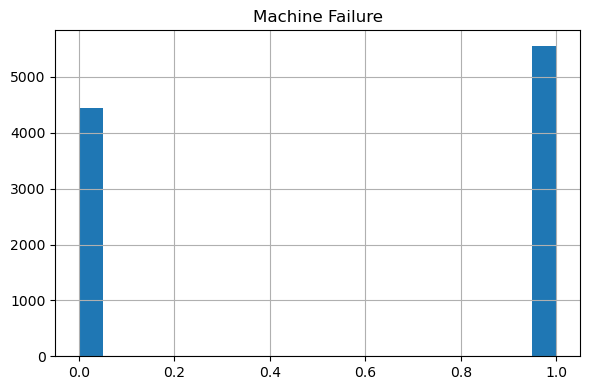

In [106]:
fake_data[label].hist(bins=20, figsize=(6, 4))
plt.tight_layout()
plt.show()

In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training and testing sets (adjust the test_size as needed)
# Assuming your dataset has a 'Machine failure' column as the target (label) and the rest are features
features = ['UDI', 'Air temperature [K]', 'Process temperature [K]',
            'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'RNF', 'OSF', 'PWF']
label = ['Machine Failure']

X = selected_data[features].values
y = selected_data[label].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree classifier on the Atraining data
dt=dt_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.999375

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1534
           1       1.00      0.98      0.99        66

    accuracy                           1.00      1600
   macro avg       1.00      0.99      1.00      1600
weighted avg       1.00      1.00      1.00      1600



In [115]:
major_count = 7722 # Adjust this count to match minor class
minor_count = 16

# Select rows for major class (Machine Failure = 0)
major_class_rows = df[df['Machine Failure'] == 0].sample(n=major_count, replace=True)

# Select rows for minor class (Machine Failure = 1)
minor_class_rows = df[df['Machine Failure'] == 1].sample(n=minor_count, replace=False)

# Concatenate the selected rows
selected_data1 = pd.concat([major_class_rows, minor_class_rows])

print(selected_data1)

      Machine Failure  UDI  Air temperature [K]  Process temperature [K]  \
5266                0  -79                  -50                       -6   
9364                0  -69                  -42                       -8   
2807                0  -67                  -42                       -6   
1595                0  -99                  -63                       -9   
7358                0  -70                  -46                       -4   
...               ...  ...                  ...                      ...   
815                 1  -55                  -34                       -7   
8120                1  -65                  -41                       -4   
444                 1  -66                  -42                      -10   
4068                1  -65                  -40                       -4   
543                 1  -60                  -39                       -7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  RNF  \
5266      

In [116]:
counts = selected_data1['Machine Failure'].value_counts()
print(counts)


0    7722
1      16
Name: Machine Failure, dtype: int64


In [117]:
selected_data1_shape = selected_data1.shape
print(selected_data1_shape)


(7738, 13)
